### Analysis software development 

Goal: establish smooth reading of the binary DAQ datafiles

In [1]:
import sys
sys.path.insert(0,'python/')
import struct
import matplotlib.pyplot as plt
import numpy as np
# import data handling class
from DT5550 import *

Filename to process

Open a datafile and read the data

In [9]:
#
# open the datfile
#
#io = DT5550(file='../../data/20211212_142706/data_20211212_142706_0.raw')
io = DT5550(indir='../../data/20211212_142706/')


for file in io.filenames:
    io.open_data(file)
    while io.read_event() == 0:
        if io.n_event%10000 == 0:
            print('Processed ',io.n_event,' events')
    

print('Processing done')

DT5550:: data recorded with config:  ../../data/20211212_142706\config_20211212_142706.json
DT5550:: Open data file: ../../data/20211212_142706\data_20211212_142706_0.raw
Processed  10000  events
DT5550:: Open data file: ../../data/20211212_142706\data_20211212_142706_1.raw
Processed  20000  events
DT5550:: Open data file: ../../data/20211212_142706\data_20211212_142706_10.raw
Processed  30000  events
DT5550:: Open data file: ../../data/20211212_142706\data_20211212_142706_11.raw
Processed  40000  events
DT5550:: Open data file: ../../data/20211212_142706\data_20211212_142706_12.raw
Processed  50000  events
DT5550:: Open data file: ../../data/20211212_142706\data_20211212_142706_13.raw
Processed  60000  events
DT5550:: Open data file: ../../data/20211212_142706\data_20211212_142706_14.raw
Processed  70000  events
DT5550:: Open data file: ../../data/20211212_142706\data_20211212_142706_15.raw
DT5550:: Open data file: ../../data/20211212_142706\data_20211212_142706_16.raw
Processed  8000

A few basic plots: integrated charge and time

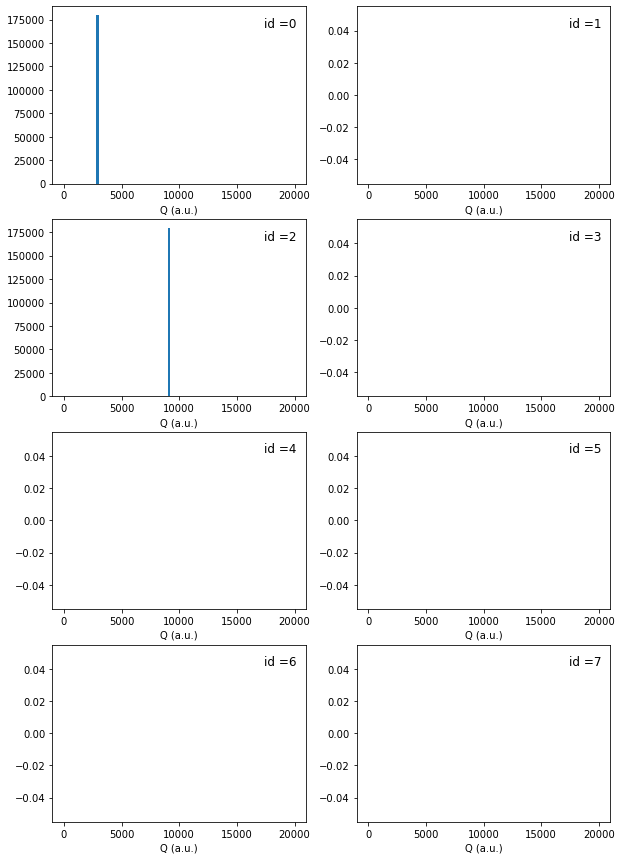

In [11]:
io.plot_all(type="charge",bins=100,logy=False, range=(0,20000))

python\DT5550.py:132: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


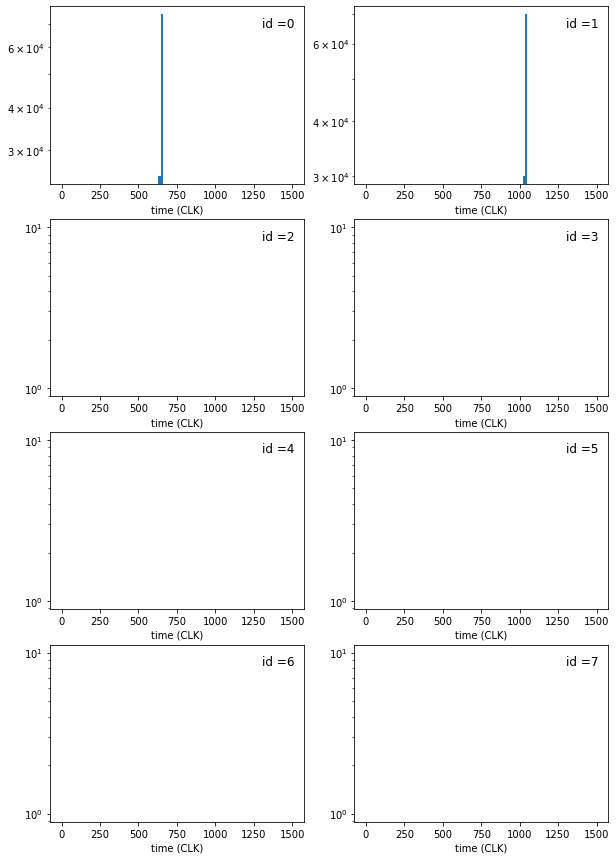

In [4]:
io.plot_all(type="time",range=(0,1500),bins=100,logy=True)